In [5]:
#Importing required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from darts import TimeSeries

%matplotlib inline

In [6]:
file_path = '../../../raw_data/processed/'
station_name = 'wenlock_road___hoxton'

In [7]:
df= pd.read_csv(file_path+f'processed_all_{station_name}_2020-01-01_2023-06-19_full_data_4.csv')

In [8]:
series = TimeSeries.from_dataframe(df, time_col='startdate', value_cols=station_name,
                                   fill_missing_dates=True, freq='H', fillna_value=0)

<Axes: xlabel='startdate'>

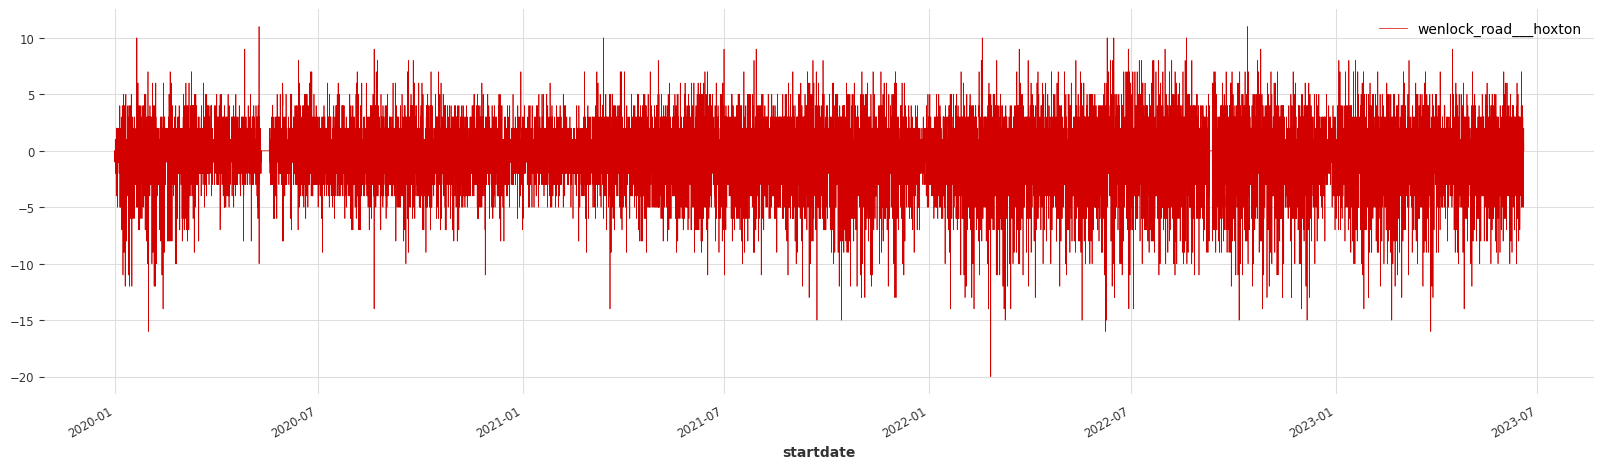

In [9]:
plt.figure(figsize=(20, 5))
series.plot(c='#D30000',linewidth=0.5)

<Axes: xlabel='startdate'>

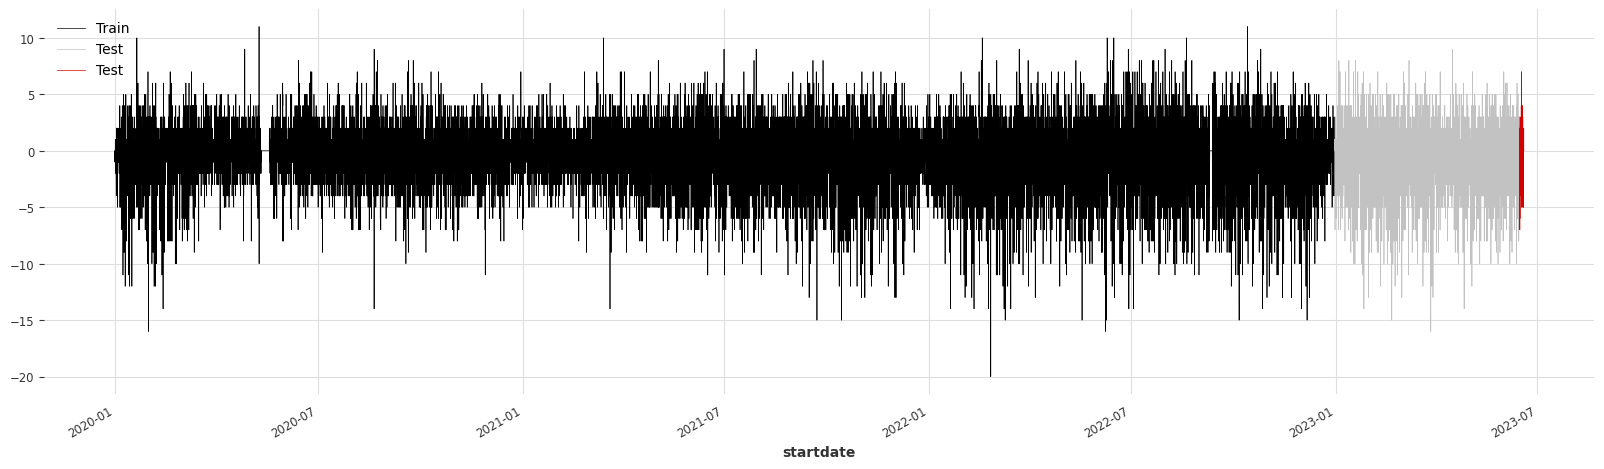

In [10]:
train, valt = series.split_before(pd.Timestamp('20221231'))
val, test = valt.split_before(pd.Timestamp('20230615'))
plt.figure(figsize=(20, 5))
train.plot(linewidth=0.5, label='Train')
val.plot(linewidth=0.5, label='Test', c='#C2C2C2')
test.plot(linewidth=0.5, label='Test', c='#D30000')


<Axes: xlabel='startdate'>

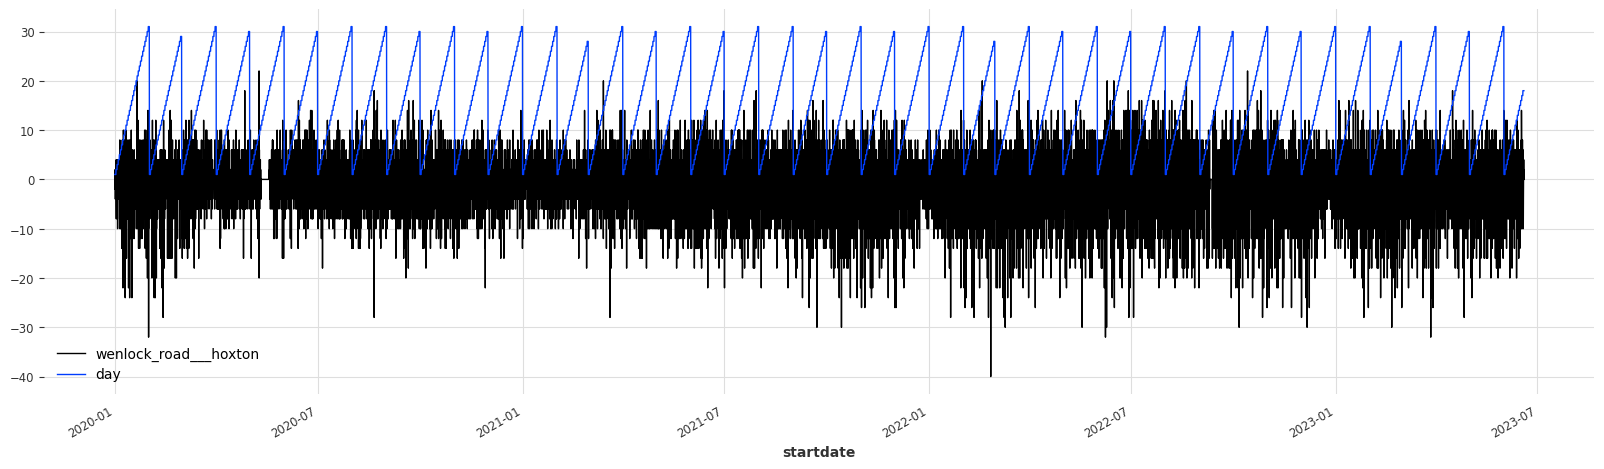

In [12]:
plt.figure(figsize=(20, 5))
(series / 0.5).add_datetime_attribute("day").plot(linewidth=1)

<Axes: xlabel='startdate'>

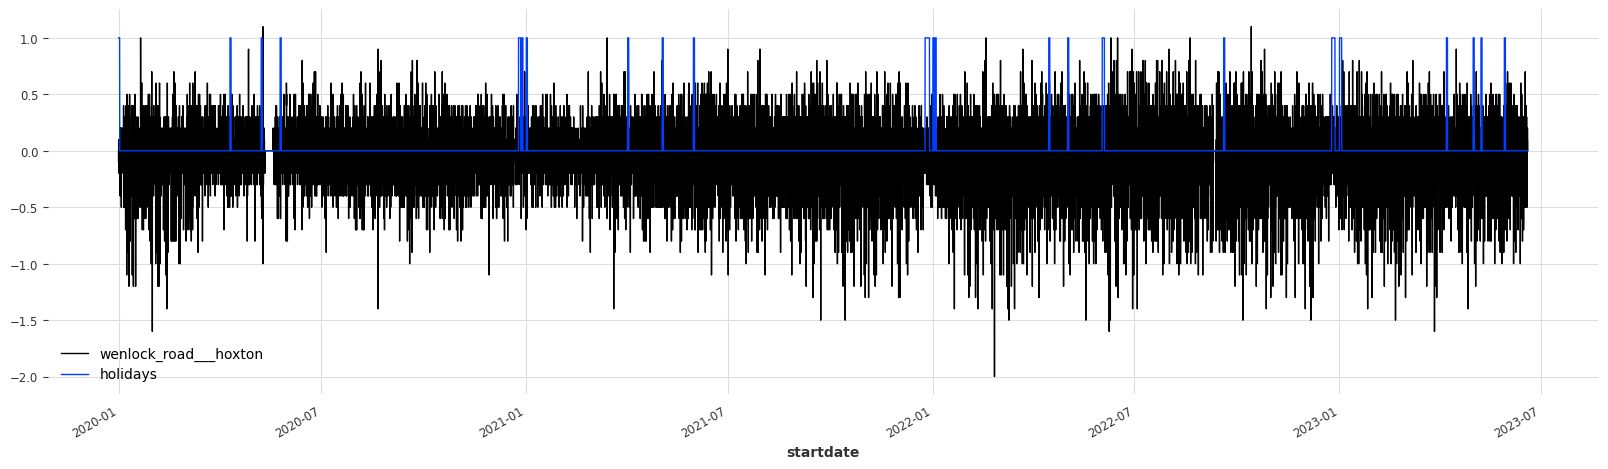

In [13]:
plt.figure(figsize=(20, 5))
(series / 10).add_holidays("UK").plot(linewidth=1)

In [15]:
from darts.models import NaiveSeasonal

The `LightGBM` module could not be imported. To enable LightGBM support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md


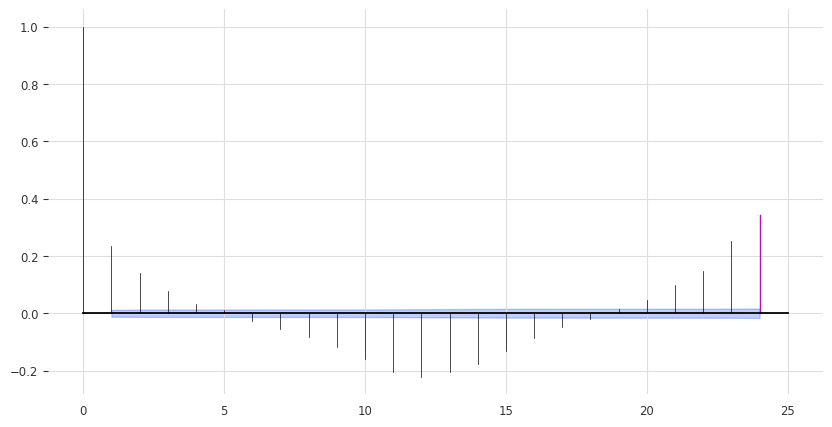

In [14]:
from darts.utils.statistics import plot_acf, check_seasonality
plot_acf(train, m=24, alpha=0.05)

In [17]:
try_periods = []
for m in range(2, 25):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))
        try_periods.append(period)

In [18]:
covariates = ['elisabeth_line', 'lockdown','strike', 'school_holidays', 'daytime', 'London_zone_Central',
       'London_zone_North', 'London_zone_West', 'London_zone_South_West',
       'London_zone_South_East', 'London_zone_East', 'Event', 'temperature',
       'rainfall', 'snowfall', 'cloudcover', 'wind_speed', 'wind_direction',
       'year', 'month', 'day', 'hour', 'weekday']

In [19]:
cov_series = TimeSeries.from_dataframe(df, time_col='startdate', 
                                       value_cols=covariates, 
                                       fill_missing_dates=True, freq='H', fillna_value=0)

<Axes: xlabel='startdate'>

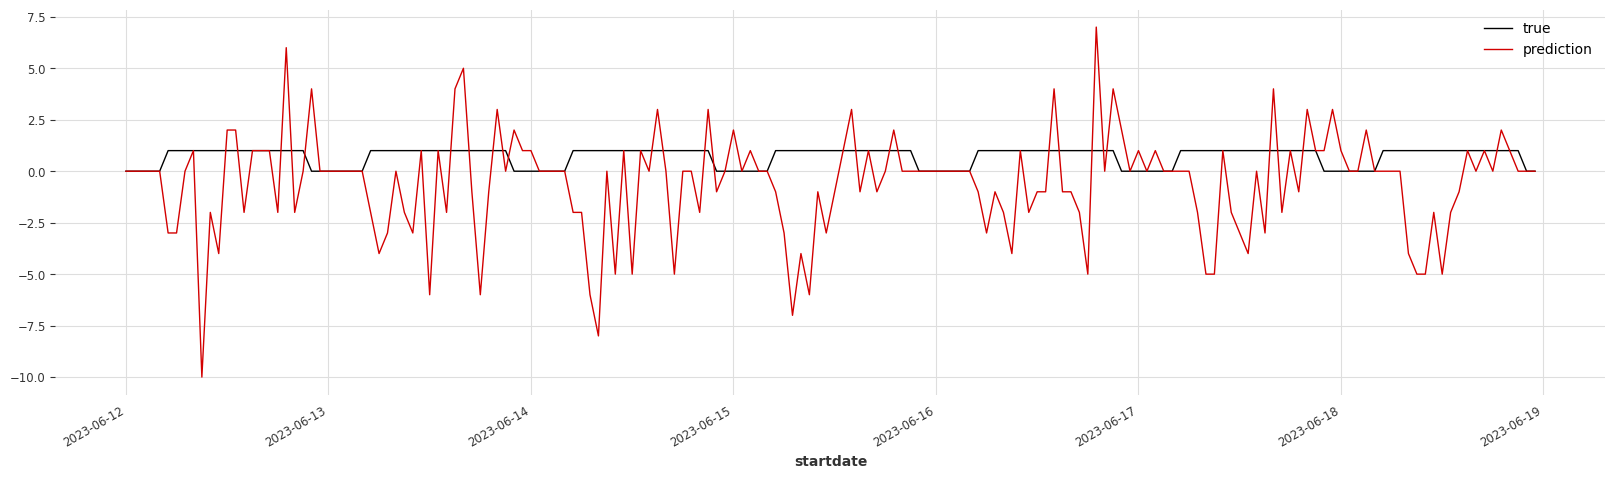

In [20]:
plt.figure(figsize=(20, 5))
cov_series[-168:]['daytime'].plot(linewidth=1, label="true")
series[-168:].plot(linewidth=1, label="prediction", c='#D30000')

In [21]:
seasonal_model = NaiveSeasonal(K=24)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(len(val))

In [15]:
traintest = train.append(val)

<Axes: xlabel='startdate'>

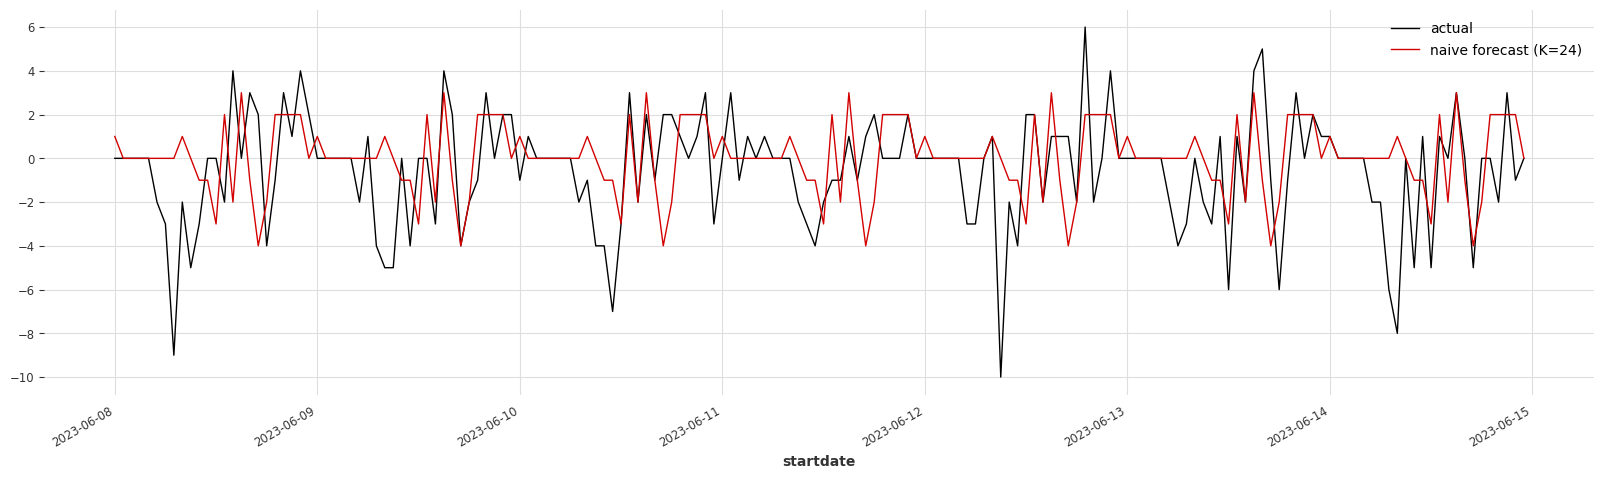

In [24]:
plt.figure(figsize=(20, 5))
traintest[-168:].plot(linewidth=1, label="actual")
seasonal_forecast[-168:].plot(linewidth=1, label="naive forecast (K=24)", c='#D30000')

In [25]:
combined_forecast = seasonal_forecast - train.last_value()

In [26]:
from darts.metrics import mae

print(
    "Mean absolute error for the combined naive seasonal: {:.2f}%.".format(
        mae(series, combined_forecast)
    )
)

Mean absolute error for the combined naive seasonal: 1.93%.


In [1]:
from darts.models import NBEATSModel

The `LightGBM` module could not be imported. To enable LightGBM support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md


In [27]:
model = NBEATSModel(input_chunk_length=24, output_chunk_length=12, random_state=42)

model.fit(
    train,
    past_covariates=cov_series,
    epochs=50,
    verbose=True,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 10.6 M
---------------------------------------------------
10.6 M    Trainable params
4.7 K     Non-trainable params
10.6 M    Total params
42.341    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


NBEATSModel(generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=24, output_chunk_length=12, random_state=42)

In [ ]:
pred = model.predict(series=train, n=len(val))

In [ ]:
plt.figure(figsize=(20, 5))
series[-168:].plot(linewidth=1, label="true")
pred[-168:].plot(linewidth=1, label="pred")

In [28]:
model.save("my_model2.pkl")

In [2]:
model_loaded = NBEATSModel.load("my_model2.pkl")

In [11]:
pred = model_loaded.predict(series=train, n=len(val))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/sebasmar/.pyenv/versions/3.10.6/envs/london-bss/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

<Axes: xlabel='startdate'>

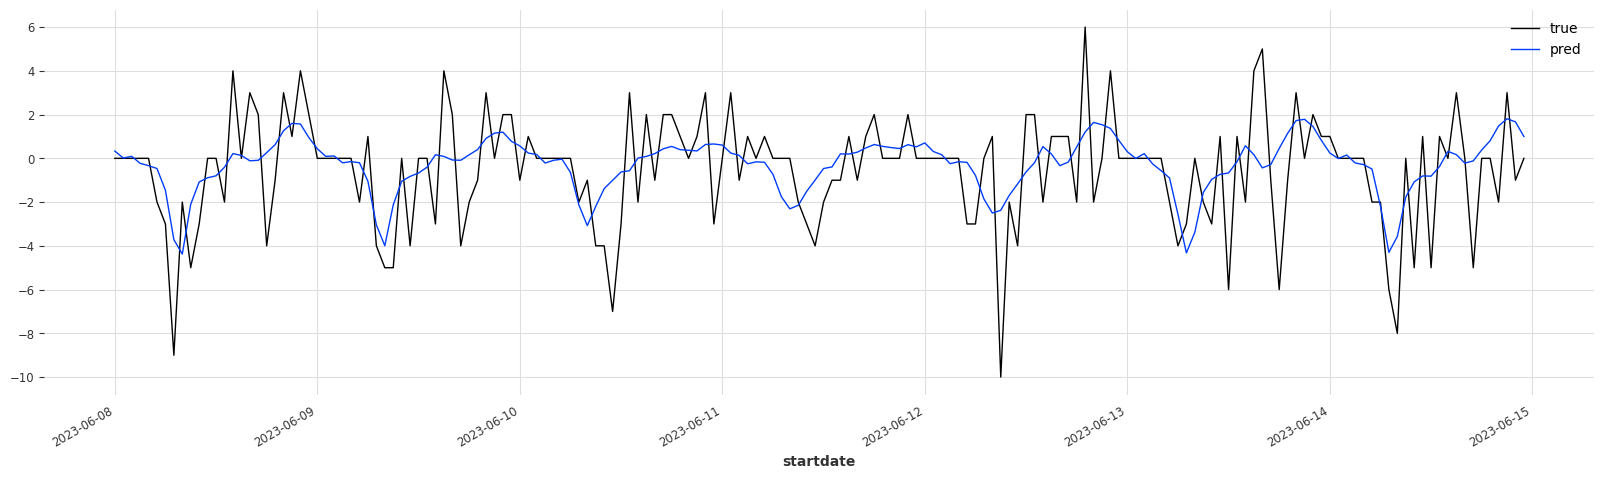

In [16]:
plt.figure(figsize=(20, 5))
traintest[-168:].plot(linewidth=1, label="true")
pred[-168:].plot(linewidth=1, label="pred")

In [18]:
pred = model_loaded.predict(series=train, n=len(val)+len(test))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/sebasmar/.pyenv/versions/3.10.6/envs/london-bss/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

<Axes: xlabel='startdate'>

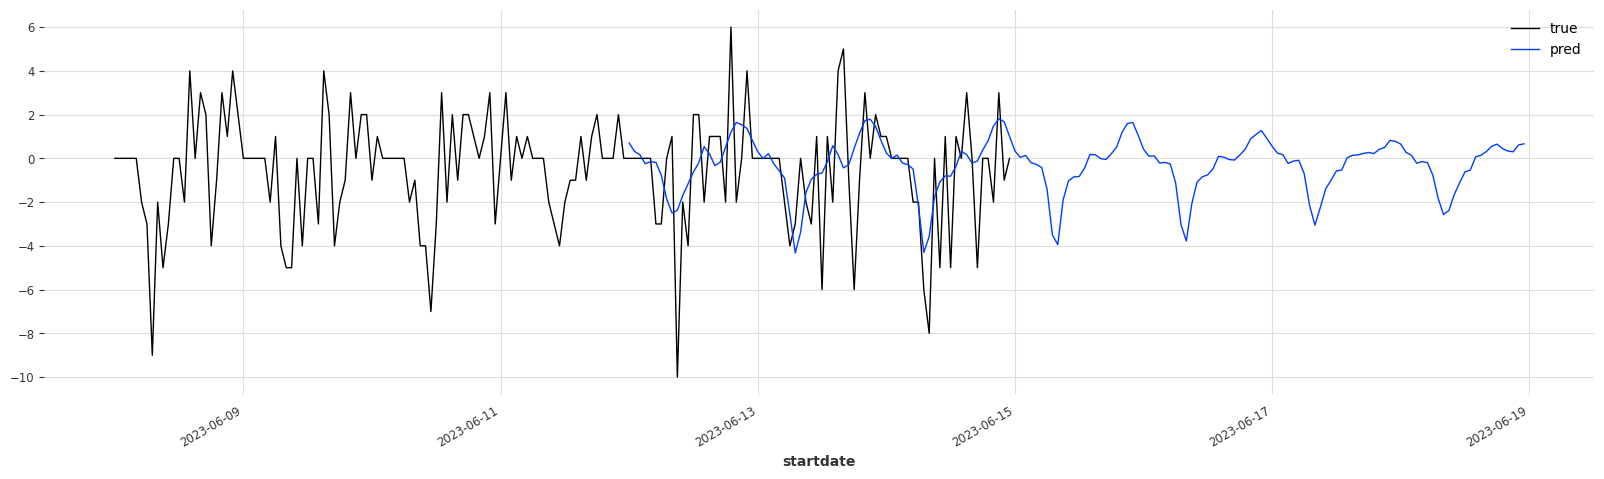

In [19]:
plt.figure(figsize=(20, 5))
traintest[-168:].plot(linewidth=1, label="true")
pred[-168:].plot(linewidth=1, label="pred")
